<a href="https://colab.research.google.com/github/jear2412/Computo-Cientifico-/blob/master/FNemcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy
import scipy.stats
import scipy.integrate
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit
from matplotlib import cm
import pytwalk
import emcee
import pystan
import time
import timeit

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from ODEclass import ODE

sns.set()

''' Fitzhugh Nagumo Model
    V: voltage across membrane
    R: recovery outward current 
    
    Two models will be implemented. 
    
    a) Model a: one parameter model for c
    b) 7 parameter model '''



' Fitzhugh Nagumo Model\n    V: voltage across membrane\n    R: recovery outward current \n    \n    Two models will be implemented. \n    \n    a) Model a: one parameter model for c\n    b) 7 parameter model '

In [ ]:
pip install emcee

     |████████████████████████████████| 51kB 1.7MB/s 


In [ ]:
def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=False)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

In [ ]:
#Fixed values
a=0.2
b=0.2
c=3. #Real value of c
sdV=0.05
sdR=0.05


#ODE definition
def Fitzhugh(X, t, c):     
    dVdt= c*( X[0]-1/3*X[0]**3+X[1]      ) 
    dRdt=-1/c*( X[0]-a+b*X[1] )
    return np.array([ dVdt, dRdt  ])    


In [ ]:
#ODE simulation

V0=-1
R0=1
X0 = np.array( [  V0, R0   ]  )

FN=ODE( X0, np.array([c]) , Fitzhugh) #creates ODE
FN.MakeGrid(0,20,100)
FN.solve()



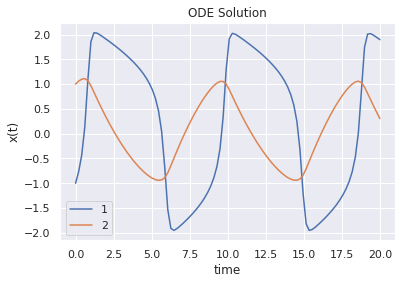

In [ ]:
FN.plot_all()

In [ ]:
Cov=np.diag([ 0.05**2 , 0.05**2 ] ) #Covariance noise matrix
FN.addNoise(Cov, key='normal'  ) #add noise 

In [ ]:
@jit(nopython=True)
def ss(y,x, cov , l):
    #c is the covariance matrix
    #l is the set of indexes of observed equations
    ss=0 #sum of squares
    for i in l:
        ss = ss-np.dot( y[:, i] - x[:, i], y[:, i] - x[:, i] )/(2*cov[i,i])
    return ss

def loglkhd(Theta,l):
    # if the error is log normal then we make x=np.log(x)
    Xt = odeint( Fitzhugh, X0, FN.t, args= (Theta,))  
    ssq=ss( FN.y,  Xt , Cov, l )
    return ssq

def post(Theta,l): #prior for c is N(14.2)
    return  -(scipy.stats.norm.logpdf(Theta,loc=14, scale=2 )+loglkhd(Theta, l))


def supp(Theta):
    return all(Theta>0)


l=(0,1)
def loglkhd1(Theta,l):
    # if the error is log normal then we make x=np.log(x)
    Xt = odeint( Fitzhugh, X0, FN.t, args= tuple(Theta))  
    ssq=ss( FN.y,  Xt , Cov, l )
    return ssq


def U(Theta):
    return -(scipy.stats.norm.logpdf(Theta,loc=14, scale=2 )+loglkhd1(Theta, l))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


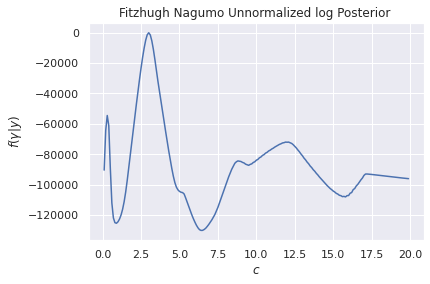

In [ ]:
l=(0,1)
xtemp=np.arange(0,20, 0.1) 
ytemp=np.zeros(len(xtemp))

for i in range(len(xtemp)):
    ytemp[i]=post( xtemp[i]  ,l )

plt.plot( xtemp, -ytemp )
plt.xlabel( r'$c$' )
plt.ylabel( r'$ f(\gamma|y)$' )
plt.title( r'Fitzhugh Nagumo Unnormalized log Posterior ' )
plt.savefig('FNpost.png', dpi=250)
plt.show()


In [ ]:

iterations=50000
bi=int(0.15*iterations)


In [ ]:
#------------ t walk MCMC 

tchain = pytwalk.pytwalk( n=1, U=U, Supp=supp )
tchain.Run( T=iterations , x0= scipy.stats.norm.rvs( loc=14, scale= 2, size=1 )  , xp0=scipy.stats.norm.rvs( loc=14, scale=1/5, size=1 )  )


pytwalk: Running the twalk with 50000 iterations .  Tue, 23 Jun 2020, 00:57:26.
       Finish in approx. 4 min and 11 sec.


/content/pytwalk.py:343: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))
/content/pytwalk.py:318: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)
/content/pytwalk.py:380: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) + (W1 - W2))
/content/pytwalk.py:304: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)


pytwalk:       5120 iterations so far. Finish in approx. 4 min and 24 sec.
pytwalk:      15360 iterations so far. Finish in approx. 3 min and 33 sec.
pytwalk:      35840 iterations so far. Finish in approx. 1 min and 24 sec.
pytwalk: finished, Tue, 23 Jun 2020, 01:02:24.


1

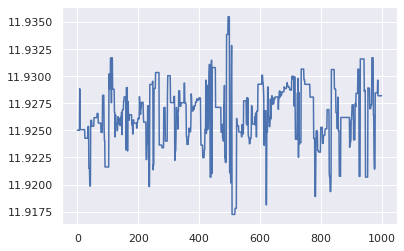

In [ ]:
x=tchain.Output[bi:,0]  
plt.plot(x[bi:bi+1000])

In [ ]:
tchain.IAT()

AutoMaxlag: maxlag= 197.


matrix([[83.94969907]])

In [ ]:
tfp.mcmc.effective_sample_size(x, filter_beyond_positive_pairs=True, validate_args=True)

<tf.Tensor: shape=(), dtype=float64, numpy=2435.1744138063236>

In [ ]:
#--------------------- emcee




